<a href="https://colab.research.google.com/github/TongshuWu1/RL_CSE337_TonyWu/blob/main/lab11_mbrl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 11: Solving the mountaincar problem in 1 episode

In this lab, you will use a Gaussian Process (GP) model to learn the dynamics of the Mountain Car system.
Then, based on Lab 8, you will use MPPI or MPPI-Simplified to write the MPC loop that controls the vehicle.
The goal is to solve the Mountain Car problem in one episode.

## Provided code
* The following code implements a Gaussian Process regression model that predicts the next-state change (Δx) given [position, velocity, action].
* Example training data collected from random actions.



In [1]:
# %matplotlib widget
%matplotlib inline

In [2]:
!pip install gpytorch


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\wts28\AppData\Local\Programs\Python\Python313\python.exe -m pip install --upgrade pip


# Gaussian Process

In [3]:
import torch
import gpytorch
import numpy as np

# ============================================================
# ---- Base Exact GP model -------------------
# ============================================================

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel='RBF', ard_dims=None):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()

        # Choose kernel type
        if kernel == 'RBF':
            base_kernel = gpytorch.kernels.RBFKernel(ard_num_dims=ard_dims)
        elif kernel == 'Matern':
            base_kernel = gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=ard_dims)
        elif kernel == 'RQ':
            base_kernel = gpytorch.kernels.RationalQuadraticKernel(ard_num_dims=ard_dims)
        else:
            raise ValueError(f"Unsupported kernel type: {kernel}")

        self.covar_module = gpytorch.kernels.ScaleKernel(base_kernel)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


# ============================================================
# ---- Individual GP Manager: handles data + normalization ----
# ============================================================

class GPManager:
    def __init__(self, kernel='RBF', lr=0.03, iters=1000):
        self.kernel = kernel
        self.lr = lr
        self.iters = iters
        self.trained = False
        self.X_train = []
        self.Y_train = []

        self.likelihood = None
        self.model = None


    # ----------------------------- #
    #        FIT / INITIAL TRAIN    #
    # ----------------------------- #
    def fit(self, X, Y):
        X = torch.tensor(X, dtype=torch.float32)
        Y = torch.tensor(Y, dtype=torch.float32)

        self.X_train = X.clone()
        self.Y_train = Y.clone()

        self.retrain()

    def retrain(self):
        # Normalize the input/output and then train the model
        self._compute_normalization()
        self._train_model()

    # ----------------------------- #
    #       ADD NEW DATA POINTS     #
    # ----------------------------- #
    def add_data(self, X_new, Y_new, retrain=True):
        """
        Add new data (single or batch) to GP training set.
        Optionally retrain the model.
        """
        X_new = torch.tensor(X_new, dtype=torch.float32)
        Y_new = torch.tensor(Y_new, dtype=torch.float32).flatten()  # ensure 1D

        # Also flatten stored Y to ensure shape consistency
        if self.Y_train.ndim > 1:
            self.Y_train = self.Y_train.flatten()

        # Append new data
        self.X_train = torch.cat([self.X_train, X_new], dim=0)
        self.Y_train = torch.cat([self.Y_train, Y_new], dim=0)

        if retrain:
            self.retrain()

    # ----------------------------- #
    #         INTERNAL UTILS        #
    # ----------------------------- #
    def _compute_normalization(self):
        self.X_mean, self.X_std = self.X_train.mean(0), self.X_train.std(0)
        self.Y_mean, self.Y_std = float(self.Y_train.mean(0)), float(self.Y_train.std(0))

        Xn = (self.X_train - self.X_mean) / self.X_std
        Yn = (self.Y_train - self.Y_mean) / self.Y_std

        self.Xn, self.Yn = Xn, Yn

    def dataset(self):
        # Extract training data (already stored inside the wrapper)
        X_train = self.X_train.numpy()
        Y_train = self.Y_train.numpy()
        return X_train, Y_train


    def _train_model(self):
        self.likelihood = gpytorch.likelihoods.GaussianLikelihood()
        self.likelihood.noise_covar.initialize(noise=1e-3)
        self.model = ExactGPModel(self.Xn, self.Yn, self.likelihood,
                                  kernel=self.kernel, ard_dims=self.X_train.shape[-1])

        # -------------------------------------------------
        # Train the model
        # -------------------------------------------------
        self.train_gp(self.model, self.likelihood, self.Xn, self.Yn)
        self.trained = True

    def train_gp(self, model, likelihood, x, y):
        model.train(); likelihood.train()
        opt = torch.optim.Adam(model.parameters(), lr=self.lr)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
        for _ in range(self.iters):
            opt.zero_grad()
            out = model(x)
            loss = -mll(out, y)
            loss.backward()
            opt.step()
        model.eval(); likelihood.eval()

    def predict(self, X):
        if not self.trained:
            raise RuntimeError("GP has not been trained yet.")

        # Normalize the input
        X = torch.as_tensor(X, dtype=torch.float32)
        Xn = (X - self.X_mean) / self.X_std
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            pred = self.likelihood(self.model(Xn))

            # Unonormalize the output
            mean = pred.mean.cpu().numpy() * self.Y_std + self.Y_mean
            var = pred.variance.cpu().numpy() * (self.Y_std ** 2)
        # Return the unnormalized output
        return mean, var


# Setup environment and collect initial data

In [4]:
import gymnasium as gym
# import gym
import numpy as np
import torch
import matplotlib.pyplot as plt

# --------------------------------------------------------------
# 1.  Environment setup
# --------------------------------------------------------------
env = gym.make("MountainCarContinuous-v0", max_episode_steps=500)
n_state = env.observation_space.shape[0]    # [position, velocity]
n_action = env.action_space.shape[0]        # 1 continuous action
n_output = 2                                # Δpos, Δvel


# --------------------------------------------------------------
# 2.  Collect initial random data
# --------------------------------------------------------------
data = {'X': [], 'Y': []}

obs, _ = env.reset(seed=0)
for _ in range(200):  # collect 500 transitions
    a = env.action_space.sample()  # random continuous action in [-1,1]
    x_next, r, term, trunc, _ = env.step(a)
    data['X'].append(np.concatenate([obs, a]))   # [pos, vel, action]
    data['Y'].append(x_next - obs)               # Δstate
    obs = x_next
    if term or trunc:
        obs, _ = env.reset()

X = np.array(data['X'])[::3]
Y = np.array(data['Y'])[::3]
print(f"Collected {len(X)} transitions.")


# --------------------------------------------------------------
# 3.  Train GP dynamics models
# --------------------------------------------------------------
gps = [GPManager(kernel='RBF', iters=300) for _ in range(n_output)]

for d in range(n_output):
    gps[d].fit(X, Y[:, d])
    print(f"Trained GP for Δstate[{d}] with {len(X)} samples.")


Collected 67 transitions.
Trained GP for Δstate[0] with 67 samples.
Trained GP for Δstate[1] with 67 samples.


# Visualize collected data

Plotting for action a=-1.0
Values near action a=-1.0 n=19


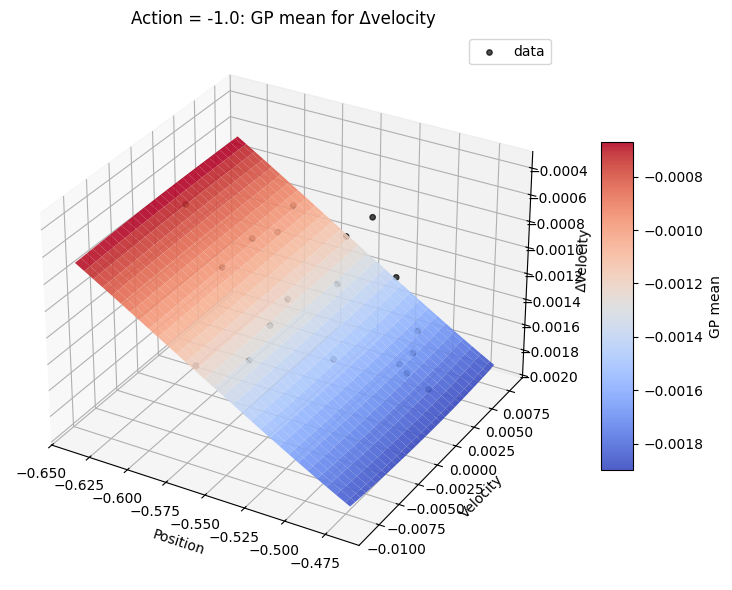

Plotting for action a=0.0
Values near action a=0.0 n=29


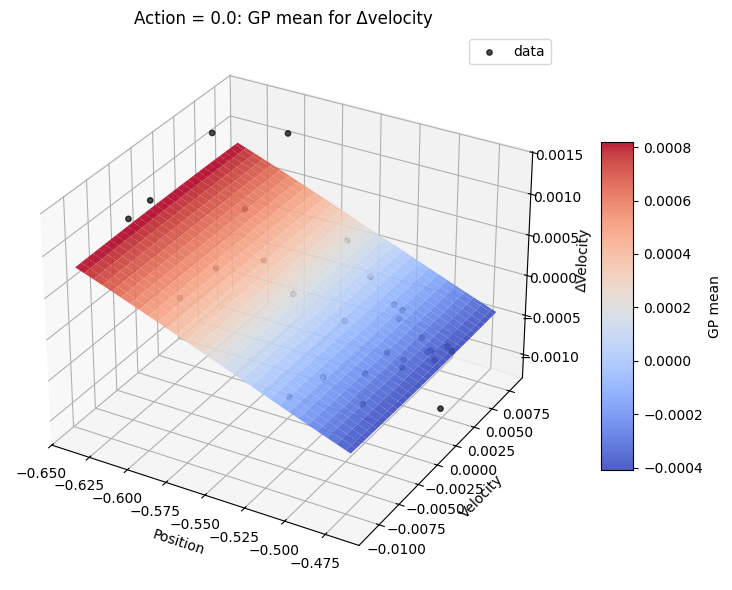

Plotting for action a=1.0
Values near action a=1.0 n=19


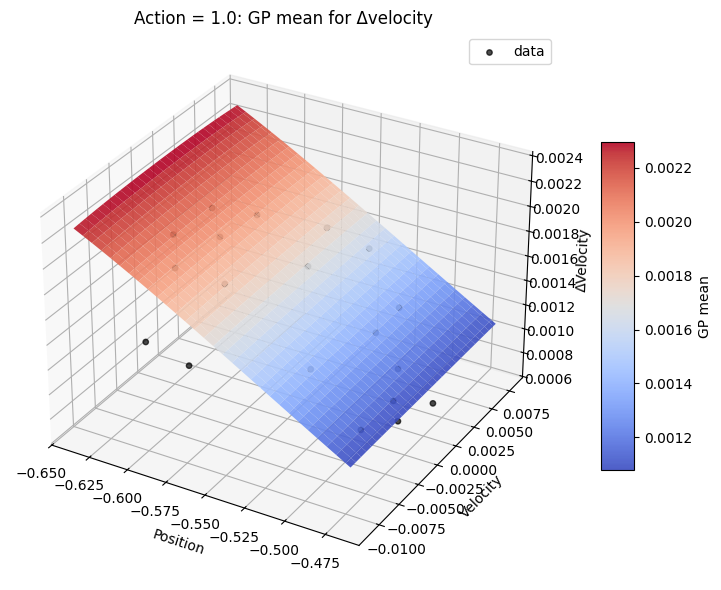

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# --------------------------------------------------------
# Visualization setup
# --------------------------------------------------------
gp = gps[1]   # GP for Δvelocity
a_values = [-1.0, 0.0, 1.0]  # representative actions

# Get raw training data
X_train, Y_train = gp.dataset()
pos, vel, act = X_train[:, 0], X_train[:, 1], X_train[:, 2]
dvel = Y_train  # Δvelocity targets

# --------------------------------------------------------
# Define grid for visualization
# --------------------------------------------------------
p_min, p_max = pos.min(), pos.max()
v_min, v_max = vel.min(), vel.max()

p_grid = np.linspace(p_min, p_max, 60)
v_grid = np.linspace(v_min, v_max, 60)
P, V = np.meshgrid(p_grid, v_grid)

# --------------------------------------------------------
# Generate and plot for each action
# --------------------------------------------------------
for a_fixed in a_values:
    print(f"Plotting for action a={a_fixed}")

    # Predict using the GP for this action
    X_grid = np.column_stack([P.ravel(), V.ravel(), np.full_like(P.ravel(), a_fixed)])
    Mean, var = gp.predict(X_grid)
    Mean = Mean.reshape(P.shape)

    # --------------------------------------------------------
    # Plot as surface
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(P, V, Mean, cmap='coolwarm',
                           linewidth=0, antialiased=True, alpha=0.9)

    # Overlay training data close to this action value
    mask = np.abs(act - a_fixed) < 0.5
    print(f"Values near action a={a_fixed} n={np.sum(mask)}")
    ax.scatter(pos[mask], vel[mask], dvel[mask],
               color='k', s=15, alpha=0.7, label='data')

    # --------------------------------------------------------
    # Labels and title
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_zlabel('ΔVelocity')
    ax.set_title(f"Action = {a_fixed:.1f}: GP mean for Δvelocity")

    fig.colorbar(surf, ax=ax, shrink=0.6, aspect=10, label='GP mean')
    ax.legend()
    plt.tight_layout()
    plt.show()


Values near action a=-1.0 → n=19


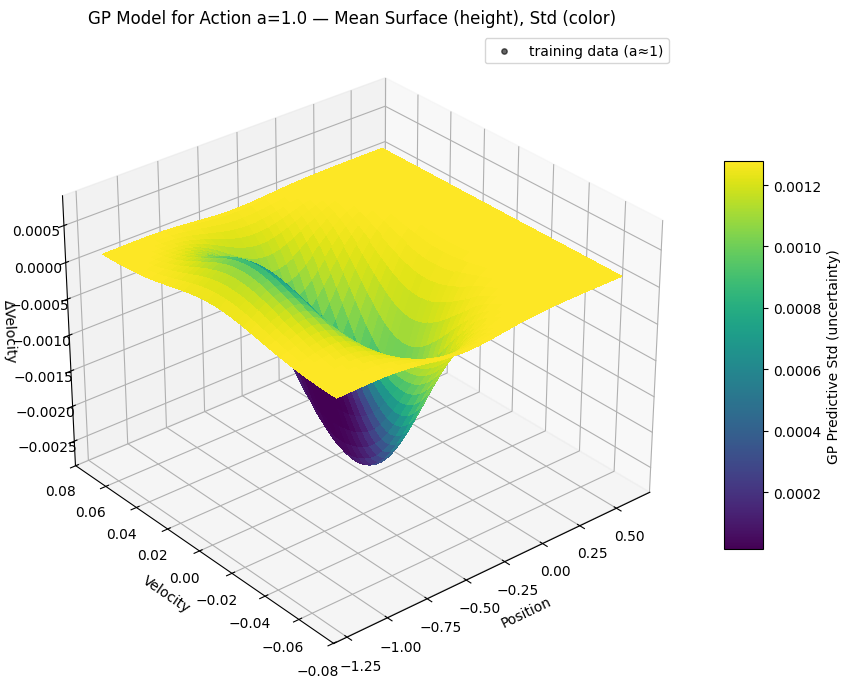

In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --------------------------------------------------------
# Choose which GP to visualize
# --------------------------------------------------------
gp = gps[1]   # GP for Δvelocity (index 0 for Δposition)
a_fixed = -1.0 # fixed continuous action (maximum thrust)

# --------------------------------------------------------
# Get training data
# --------------------------------------------------------
X_train, Y_train = gp.dataset()
pos, vel, act = X_train[:, 0], X_train[:, 1], X_train[:, 2]
dvel = Y_train

# Select samples close to a=1 for overlay
mask = np.abs(act - a_fixed) < 0.5
print(f"Values near action a={a_fixed} → n={np.sum(mask)}")

# --------------------------------------------------------
# Define position–velocity grid
# --------------------------------------------------------
p_min, p_max = -1.2, 0.6
v_min, v_max = -0.07, 0.07
p_grid = np.linspace(p_min, p_max, 80)
v_grid = np.linspace(v_min, v_max, 80)
P, V = np.meshgrid(p_grid, v_grid)

# Query points for the fixed action
X_grid = np.column_stack([P.ravel(), V.ravel(), np.full_like(P.ravel(), a_fixed)])

# --------------------------------------------------------
# GP predictions
# --------------------------------------------------------
Mean, Var = gp.predict(X_grid)
Mean = Mean.reshape(P.shape)
Std = np.sqrt(Var.reshape(P.shape))

# Normalize Std for color mapping
norm = plt.Normalize(vmin=Std.min(), vmax=Std.max())
colors = plt.cm.viridis(norm(Std))

# --------------------------------------------------------
# Plot surface: Mean as height, Std as color
# --------------------------------------------------------
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(
    P, V, Mean,
    facecolors=colors, linewidth=0, antialiased=False, shade=False
)

# Colorbar = predictive uncertainty
m = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
m.set_array(Std)
cbar = fig.colorbar(m, ax=ax, shrink=0.6, aspect=10)
cbar.set_label('GP Predictive Std (uncertainty)')

# Overlay raw data (samples with similar a)
ax.scatter(
    pos[mask], vel[mask], dvel[mask],
    color='k', s=15, alpha=0.6, label='training data (a≈1)'
)

# --------------------------------------------------------
# Labels and title
# --------------------------------------------------------
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_zlabel('ΔVelocity')
ax.set_title("GP Model for Action a=1.0 — Mean Surface (height), Std (color)")
ax.view_init(elev=30, azim=230)
ax.legend()
plt.tight_layout()
plt.show()



 Retraining GP on new dataset 
   GP step 100/500 | loss = -0.4016
   GP step 200/500 | loss = -1.8534
   GP step 300/500 | loss = -2.7805
   GP step 400/500 | loss = -3.0379
   GP step 500/500 | loss = -3.1227
GP retrain complete.


 Retraining GP on new dataset 
   GP step 100/500 | loss = -0.4017
   GP step 200/500 | loss = -1.8495
   GP step 300/500 | loss = -2.7835
   GP step 400/500 | loss = -3.0431
   GP step 500/500 | loss = -3.1265
GP retrain complete.


=========== START ACTIVE LEARNING ===========


======== ACTIVE CYCLE 1 ========
[MPPI] step=0 | a0=+0.085 | Jmin=9780.66
[MPPI] step=5 | a0=+0.185 | Jmin=9519.57
[MPPI] step=10 | a0=+0.308 | Jmin=9254.05
[MPPI] step=15 | a0=+0.711 | Jmin=9062.60
[MPPI] step=20 | a0=+0.728 | Jmin=8850.32
[MPPI] step=25 | a0=+0.893 | Jmin=8660.03
[MPPI] step=30 | a0=+0.890 | Jmin=8641.02
[MPPI] step=35 | a0=+0.964 | Jmin=8622.71
[MPPI] step=40 | a0=+0.966 | Jmin=8721.64
[MPPI] step=45 | a0=+0.921 | Jmin=8880.11
[MPPI] step=50 | a0=+0.956 | Jmi

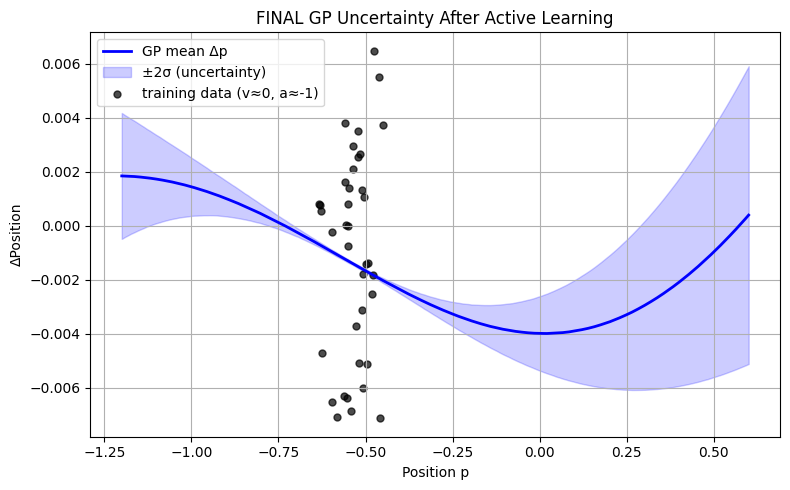

In [19]:
%matplotlib inline
import numpy as np
import torch
import gpytorch
import gymnasium as gym
import matplotlib.pyplot as plt


# ============================================================
# 1. GP MODEL FROM HOMEWORK (UNCHANGED)
# ============================================================

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel='RBF', ard_dims=None):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()

        if kernel == 'RBF':
            base_kernel = gpytorch.kernels.RBFKernel(ard_num_dims=ard_dims)
        else:
            base_kernel = gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=ard_dims)

        self.covar_module = gpytorch.kernels.ScaleKernel(base_kernel)

    def forward(self, x):
        return gpytorch.distributions.MultivariateNormal(
            self.mean_module(x), self.covar_module(x)
        )


class GPManager:
    def __init__(self, kernel='RBF', lr=0.03, iters=500):
        self.kernel = kernel
        self.lr = lr
        self.iters = iters
        self.trained = False

    def fit(self, X, Y):
        print("\n==============================")
        print(" Retraining GP on new dataset ")
        print("==============================")

        X = torch.tensor(X, dtype=torch.float32)
        Y = torch.tensor(Y, dtype=torch.float32)

        # Normalize
        self.X_mean = X.mean(0)
        self.X_std = X.std(0)
        Xn = (X - self.X_mean) / self.X_std

        self.Y_mean = Y.mean()
        self.Y_std = Y.std()
        Yn = (Y - self.Y_mean) / self.Y_std

        self.likelihood = gpytorch.likelihoods.GaussianLikelihood()
        self.model = ExactGPModel(Xn, Yn, self.likelihood,
                                  kernel=self.kernel, ard_dims=X.shape[-1])

        # Training
        self.model.train()
        self.likelihood.train()
        opt = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihood, self.model)

        self.loss_track = []

        for i in range(self.iters):
            opt.zero_grad()
            pred = self.model(Xn)
            loss = -mll(pred, Yn)
            loss.backward()
            opt.step()
            self.loss_track.append(loss.item())

            if (i+1) % 100 == 0:
                print(f"   GP step {i+1}/{self.iters} | loss = {loss.item():.4f}")

        self.model.eval()
        self.likelihood.eval()
        self.trained = True

        print("GP retrain complete.\n")

    def predict(self, X):
        X = torch.tensor(X, dtype=torch.float32)
        Xn = (X - self.X_mean) / self.X_std
        with torch.no_grad():
            pred = self.model(Xn)
        mean = pred.mean.numpy() * float(self.Y_std) + float(self.Y_mean)
        var = pred.variance.numpy() * float(self.Y_std)**2
        return mean, var

    def dataset(self):
        return self.X_train, self.Y_train


# ============================================================
# 2. INITIAL GP TRAINING DATA
# ============================================================

env = gym.make("MountainCarContinuous-v0", max_episode_steps=500)
dataX, dataY = [], []

obs, _ = env.reset(seed=1)
for _ in range(300):
    a = env.action_space.sample()
    next_obs, _, term, trunc, _ = env.step(a)
    dataX.append(np.concatenate([obs, a]))
    dataY.append(next_obs - obs)
    obs = next_obs
    if term or trunc:
        obs, _ = env.reset()

X = np.array(dataX)[::2]
Y = np.array(dataY)[::2]

gps = [GPManager(iters=500), GPManager(iters=500)]
gps[0].fit(X, Y[:, 0])
gps[1].fit(X, Y[:, 1])


# ============================================================
# 3. FAST GP STEP WITH VARIANCE
# ============================================================

def gp_step_mean_var(states, actions):
    N = states.shape[0]
    inp = np.zeros((N, 3), dtype=np.float32)
    inp[:, :2] = states
    inp[:, 2] = actions

    mean_p, var_p = gps[0].predict(inp)
    mean_v, var_v = gps[1].predict(inp)

    next_states = states.copy()
    next_states[:, 0] += mean_p
    next_states[:, 1] += mean_v

    return next_states, var_p + var_v


# ============================================================
# 4. COST FUNCTIONS
# ============================================================

GOAL = 0.45

def task_cost(states, actions):
    x = states[:, 0]
    v = states[:, 1]
    dist = np.abs(x - GOAL)

    pos = 300 * (np.tanh(dist * 2) ** 2)
    vel = (150 + 3000 * np.exp(-20 * dist)) * (v ** 2)
    energy = 1.0 * (actions ** 2)
    time = 1.5
    steady = np.where((dist < 0.03) & (np.abs(v) < 0.005), -1000.0, 0.0)
    return pos + vel + energy + time + steady

def explore_cost(var):
    return -var


# ============================================================
# 5. ACTIVE LEARNING MPPI
# ============================================================

class ActiveMPPI:
    def __init__(self):
        self.H = 60
        self.K = 400
        self.sigma = 0.6
        self.lam = 1.0
        self.gamma = 0.99
        self.U_mean = np.zeros(self.H, dtype=np.float32)
        self.debug_step = 0

    def action(self, state):
        noise = np.random.randn(self.K, self.H).astype(np.float32) * self.sigma
        U = np.clip(self.U_mean + noise, -1, 1)

        S = np.repeat(state[None, :], self.K, axis=0)
        taskJ = np.zeros(self.K)
        exploreJ = np.zeros(self.K)
        disc = 1.0

        for t in range(self.H):
            a_t = U[:, t]
            S, var = gp_step_mean_var(S, a_t)
            taskJ += task_cost(S, a_t) * disc
            exploreJ += explore_cost(var) * disc
            disc *= self.gamma

        J = 0.8 * taskJ + 0.2 * exploreJ

        Jmin = J.min()
        w = np.exp(-(J - Jmin) / (self.lam + 1e-6))
        w /= w.sum()

        new_mean = np.sum(U * w[:, None], axis=0)
        self.U_mean = 0.8 * self.U_mean + 0.2 * new_mean

        if self.debug_step % 5 == 0:
            print(f"[MPPI] step={self.debug_step} | a0={self.U_mean[0]:+.3f} | Jmin={Jmin:.2f}")

        self.debug_step += 1
        return float(self.U_mean[0])


# ============================================================
# 6. EXPLORATION EPISODE (COLLECT)
# ============================================================

def run_explore_episode():
    env = gym.make("MountainCarContinuous-v0", max_episode_steps=500, render_mode="human")
    obs, _ = env.reset()

    ctrl = ActiveMPPI()
    newX, newY = [], []

    for _ in range(150):
        a = ctrl.action(obs)
        next_obs, _, term, trunc, _ = env.step([a])
        newX.append(np.concatenate([obs, [a]]))
        newY.append(next_obs - obs)

        obs = next_obs
        if term or trunc:
            break

    env.close()
    return np.array(newX), np.array(newY)


# ============================================================
# 7. TASK EPISODE — SUCCESS CHECK
# ============================================================

def run_task_episode():
    env = gym.make("MountainCarContinuous-v0", max_episode_steps=500, render_mode="human")
    obs, _ = env.reset()

    ctrl = ActiveMPPI()
    for t in range(300):
        a = ctrl.action(obs)
        obs, _, term, trunc, _ = env.step([a])
        if obs[0] >= GOAL:
            env.close()
            return True  # SUCCESS!
        if term or trunc:
            break

    env.close()
    return False


# ============================================================
# 8. ACTIVE LEARNING LOOP UNTIL SUCCESS
# ============================================================

print("\n=========== START ACTIVE LEARNING ===========")
cycle = 0

while True:
    cycle += 1
    print(f"\n\n======== ACTIVE CYCLE {cycle} ========")

    # Exploration
    newX, newY = run_explore_episode()
    print(f"Collected {len(newX)} new samples.")

    # Merge data
    X = np.vstack([X, newX])
    Y = np.vstack([Y, newY])

    # Retrain GP
    gps[0].fit(X, Y[:, 0])
    gps[1].fit(X, Y[:, 1])

    # Test task episode
    print("Testing task episode...")
    success = run_task_episode()

    if success:
        print("\n🎉 SUCCESS! MountainCar reached the goal.")
        break


# ============================================================
# 9. FINAL UNCERTAINTY PLOT (YOUR EXACT HOMEWORK PLOT)
# ============================================================

gp = gps[0]  # Δposition model
v_fixed = 0.0
a_fixed = -1.0

p_grid = np.linspace(-1.2, 0.6, 200)
X_query = np.column_stack([p_grid, np.full_like(p_grid, v_fixed), np.full_like(p_grid, a_fixed)])

Mean, Var = gp.predict(X_query)
Std = np.sqrt(Var)

plt.figure(figsize=(8, 5))
plt.plot(p_grid, Mean, 'b-', lw=2, label='GP mean Δp')
plt.fill_between(p_grid, Mean - 2*Std, Mean + 2*Std, color='blue', alpha=0.2,
                 label='±2σ (uncertainty)')

# Overlay training data near v≈0, a≈-1
X_train, Y_train = X, Y[:,0]
mask = (np.abs(X_train[:, 1] - v_fixed) < 0.01) & (np.abs(X_train[:, 2] - a_fixed) < 0.5)
plt.scatter(X_train[mask, 0], Y_train[mask], color='k', s=25, alpha=0.7,
            label='training data (v≈0, a≈-1)')

plt.xlabel("Position p")
plt.ylabel("ΔPosition")
plt.title("FINAL GP Uncertainty After Active Learning")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Exercise 1
Use the trained GP as a learned dynamics model to control the Mountain Car environment using Model Predictive Control (MPC).

You can choose between:
* MPPI (Model Predictive Path Integral) – probabilistic trajectory weighting, or
* MPPI-Simplified (Random Shooting) – select the lowest-cost trajectory among random samples.

Your controller should plan ahead, predict future states using the GP, and drive the car to reach the goal in a single episode.

### Expected Outcome
By the end of the exercise, your controller should:
* Use the GP model to predict the system dynamics
* Plan and select optimal actions using MPC
* Drive the car to reach the goal in one episode

### Deliverables

* Your implementation of the mpc_action() function
* A plot showing the car’s position versus time
* A short explanation (2–3 sentences) describing how MBRL is more efficient than Q-learning.
* Describe the downside of MBRL over Q-learning

# MPC


Collected samples: 150
Training GP (CPU)…
GP trained.
Training GP (CPU)…
GP trained.
[MPPI] step=0  a0=+0.176  Jmin=15100.83
[MPPI] step=5  a0=-0.292  Jmin=14827.45
[MPPI] step=10  a0=-0.332  Jmin=14431.00
[MPPI] step=15  a0=-0.715  Jmin=13852.16
[MPPI] step=20  a0=-0.649  Jmin=13394.69
[MPPI] step=25  a0=-0.617  Jmin=13016.61
[MPPI] step=30  a0=-0.714  Jmin=12631.48
[MPPI] step=35  a0=-0.785  Jmin=12322.06
[MPPI] step=40  a0=-0.812  Jmin=11896.45
[MPPI] step=45  a0=-0.558  Jmin=11415.79
[MPPI] step=50  a0=-0.109  Jmin=11319.93
[MPPI] step=55  a0=-0.016  Jmin=11617.21
[MPPI] step=60  a0=+0.547  Jmin=11815.24
[MPPI] step=65  a0=+0.721  Jmin=10774.18
[MPPI] step=70  a0=+0.553  Jmin=10933.12
[MPPI] step=75  a0=+0.782  Jmin=10730.27
[MPPI] step=80  a0=+0.929  Jmin=10361.90
[MPPI] step=85  a0=+0.963  Jmin=10142.83
[MPPI] step=90  a0=+0.964  Jmin=9619.17
[MPPI] step=95  a0=+0.988  Jmin=8955.47
[MPPI] step=100  a0=+0.967  Jmin=8208.84
[MPPI] step=105  a0=+0.989  Jmin=6719.96
[MPPI] step=110  

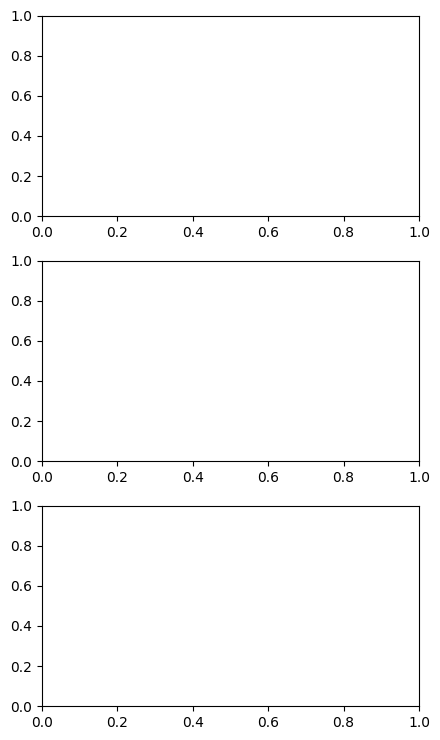

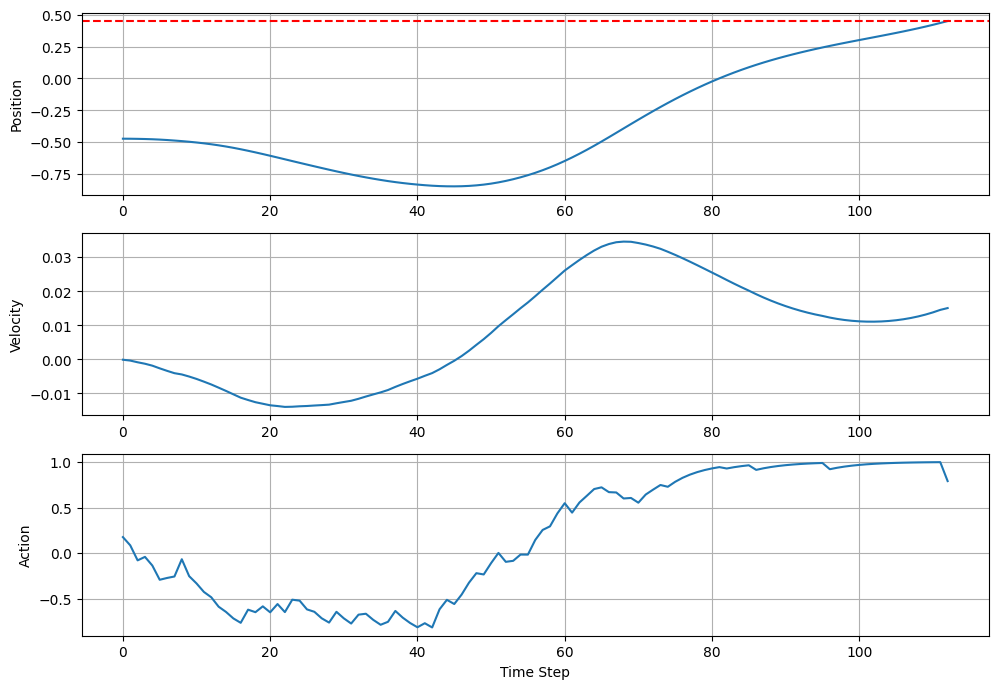

In [15]:
%matplotlib inline

import numpy as np
import torch
import gpytorch
import gymnasium as gym
import matplotlib.pyplot as plt



class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel='RBF', ard_dims=None):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()

        if kernel == 'RBF':
            base_kernel = gpytorch.kernels.RBFKernel(ard_num_dims=ard_dims)
        else:
            base_kernel = gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=ard_dims)

        self.covar_module = gpytorch.kernels.ScaleKernel(base_kernel)

    def forward(self, x):
        return gpytorch.distributions.MultivariateNormal(
            self.mean_module(x), self.covar_module(x)
        )


class GPManager:
    def __init__(self, kernel='RBF', lr=0.03, iters=600):
        self.kernel = kernel
        self.lr = lr
        self.iters = iters

    def fit(self, X, Y):
        print("Training GP (CPU)…")

        X = torch.tensor(X, dtype=torch.float32)
        Y = torch.tensor(Y, dtype=torch.float32)

        self.X_mean = X.mean(0)
        self.X_std = X.std(0)
        Xn = (X - self.X_mean) / self.X_std

        self.Y_mean = Y.mean()
        self.Y_std = Y.std()
        Yn = (Y - self.Y_mean) / self.Y_std

        self.likelihood = gpytorch.likelihoods.GaussianLikelihood()
        self.model = ExactGPModel(Xn, Yn, self.likelihood,
                                  kernel=self.kernel, ard_dims=X.shape[-1])

        self.model.train()
        self.likelihood.train()

        opt = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihood, self.model)

        for i in range(self.iters):
            opt.zero_grad()
            pred = self.model(Xn)
            loss = -mll(pred, Yn)
            loss.backward()
            opt.step()

        self.model.eval()
        self.likelihood.eval()

        print("GP trained.")

    def predict_fast(self, X):
        X = torch.tensor(X, dtype=torch.float32)
        Xn = (X - self.X_mean) / self.X_std
        with torch.no_grad():
            pred = self.model(Xn)
        return pred.mean.numpy() * float(self.Y_std) + float(self.Y_mean)



env = gym.make("MountainCarContinuous-v0", max_episode_steps=500)
dataX, dataY = [], []

obs, _ = env.reset(seed=0)
for _ in range(300):
    a = env.action_space.sample()
    next_obs, _, term, trunc, _ = env.step(a)
    dataX.append(np.concatenate([obs, a]))
    dataY.append(next_obs - obs)
    obs = next_obs
    if term or trunc:
        obs, _ = env.reset()

X = np.array(dataX)[::2]
Y = np.array(dataY)[::2]

print("Collected samples:", len(X))

gps = [GPManager(iters=600), GPManager(iters=600)]
gps[0].fit(X, Y[:, 0])
gps[1].fit(X, Y[:, 1])



def gp_step_fast(states, actions):
    N = states.shape[0]
    inp = np.zeros((N, 3), dtype=np.float32)
    inp[:, :2] = states
    inp[:, 2] = actions

    dpos = gps[0].predict_fast(inp)
    dvel = gps[1].predict_fast(inp)

    next_states = np.empty_like(states)
    next_states[:, 0] = states[:, 0] + dpos
    next_states[:, 1] = states[:, 1] + dvel
    return next_states


GOAL = 0.45

STOP_WEIGHTS = dict(
    position=300,
    velocity=200,
    energy=1.0,
    stop_boost=4000.0,
    time=2.0,
)

def cost_map(states, actions, w):
    x = states[:, 0]
    v = states[:, 1]
    dist = np.abs(x - GOAL)

    pos = w["position"] * (np.tanh(dist * 2) ** 2)
    vel = (w["velocity"] + w["stop_boost"] * np.exp(-20 * dist)) * (v ** 2)
    energy = w["energy"] * (actions ** 2)
    time = w["time"]
    steady = np.where((dist < 0.03) & (np.abs(v) < 0.005), -1000.0, 0.0)

    return pos + vel + energy + time + steady


class FastMPPI:
    def __init__(self, gps):
        self.H = 80
        self.K = 512
        self.sigma = 0.6
        self.lam = 1.0
        self.gamma = 0.99
        self.U_mean = np.zeros(self.H, dtype=np.float32)
        self.gps = gps
        self.debug_step = 0

    def action(self, state):
        noise = np.random.randn(self.K, self.H).astype(np.float32) * self.sigma
        U = np.clip(self.U_mean + noise, -1, 1)

        S = np.repeat(state[None, :], self.K, axis=0)
        costs = np.zeros(self.K)
        disc = 1.0

        for t in range(self.H):
            a_t = U[:, t]
            S = gp_step_fast(S, a_t)
            costs += cost_map(S, a_t, STOP_WEIGHTS) * disc
            disc *= self.gamma

        Jmin = costs.min()
        weights = np.exp(-(costs - Jmin) / (self.lam + 1e-6))
        weights /= weights.sum()

        new_mean = np.sum(U * weights[:, None], axis=0)
        self.U_mean = 0.8 * self.U_mean + 0.2 * new_mean

        if self.debug_step % 5 == 0:
            print(f"[MPPI] step={self.debug_step}  a0={self.U_mean[0]:+.3f}  Jmin={Jmin:.2f}")

        self.debug_step += 1
        return float(self.U_mean[0])


def run_mppi_human():
    env = gym.make("MountainCarContinuous-v0", render_mode="human")
    obs, _ = env.reset(seed=0)

    ctrl = FastMPPI(gps)
    pos_hist, vel_hist, act_hist = [], [], []

    for t in range(500):
        a = ctrl.action(obs)
        obs, _, term, trunc, _ = env.step([a])

        pos_hist.append(obs[0])
        vel_hist.append(obs[1])
        act_hist.append(a)

        if term or trunc:
            break

    env.close()
    return np.array(pos_hist), np.array(vel_hist), np.array(act_hist)


pos_hist, vel_hist, act_hist = run_mppi_human()

plt.figure(figsize=(10, 7))

plt.subplot(3, 1, 1)
plt.plot(pos_hist)
plt.axhline(GOAL, color='r', linestyle='--')
plt.ylabel("Position")
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(vel_hist)
plt.ylabel("Velocity")
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(act_hist)
plt.ylabel("Action")
plt.xlabel("Time Step")
plt.grid(True)

plt.tight_layout()
plt.show()


MBRL is more efficient than Q-learning because it learns a model of the environment and can simulate many future steps without needing real interactions. This lets the agent improve its policy using fewer samples, while Q-learning must collect a lot more experience directly from the environment.

The downside is that MBRL depends on how accurate the learned model is. If the model is wrong, the planner can make bad decisions, while Q-learning is slower but does not suffer from model errors.



# Exercise 2 (Graduate students)
Extend the MPC controller from Exercise 1 by incorporating Gaussian Process (GP) uncertainty into the MPPI algorithm.
The goal is to study how including the GP’s predictive variance affects control performance and sample efficiency.


* Include GP uncertainty (variance) in the MPPI algorithm.
Modify the cost function or trajectory weighting so that trajectories passing through regions of high model uncertainty are penalized.

* Compare two systems:
  * MPPI using only the GP mean prediction (deterministic model).
  * MPPI using both the GP mean and variance (uncertainty-aware model).
* Evaluate and discuss the results:
  * The MBRL system from Exercise 1 usually solves the Mountain Car problem in more than 100 steps, even after several episodes.
  * Investigate whether incorporating uncertainty can help the controller reach the goal faster or with fewer samples.
  * Provide plots of position over time for both cases.

## Deliverables

* Your modified MPPI implementation that includes GP variance.
* Two plots comparing:
    * Position vs. time (with and without variance)
    * Cumulative reward or number of steps to reach the goal
* A short discussion (2–3 paragraphs) explaining how including uncertainty affects performance and why it might lead to better results.

Training GP…
GP trained.

Training GP…
GP trained.


===== CYCLE 1/5 =====
Extending main episode by +50 steps (frontier x=-0.475)
[MPPI] step=0  a0=-0.040  Jmin=16490.53
[MPPI] step=10  a0=-0.227  Jmin=15980.28
[MPPI] step=20  a0=+0.412  Jmin=15318.59
[MPPI] step=30  a0=+0.699  Jmin=14627.05
[MPPI] step=40  a0=+0.888  Jmin=14184.38
[MPPI] step=0  a0=-0.005  Jmin=-0.00
[MPPI] step=10  a0=+0.023  Jmin=-0.00
[MPPI] step=20  a0=+0.035  Jmin=-0.00
[MPPI] step=30  a0=+0.057  Jmin=-0.00
[MPPI] step=40  a0=+0.058  Jmin=-0.00
[MPPI] step=50  a0=+0.052  Jmin=-0.00
[MPPI] step=60  a0=+0.038  Jmin=-0.00
[MPPI] step=70  a0=+0.058  Jmin=-0.00
[MPPI] step=80  a0=+0.062  Jmin=-0.00
[MPPI] step=90  a0=+0.061  Jmin=-0.00
Collected new exploration samples: 100
Retraining GPs on all data …
Training GP…
GP trained.

Training GP…
GP trained.


=== Model Analysis (after retrain) ===
[Δpos GP] lengthscales (pos, vel, act): [7.7577 4.5858 8.9885]  | outputscale: 3.4739  | noise: 0.000114
[Δvel GP] lengthscale

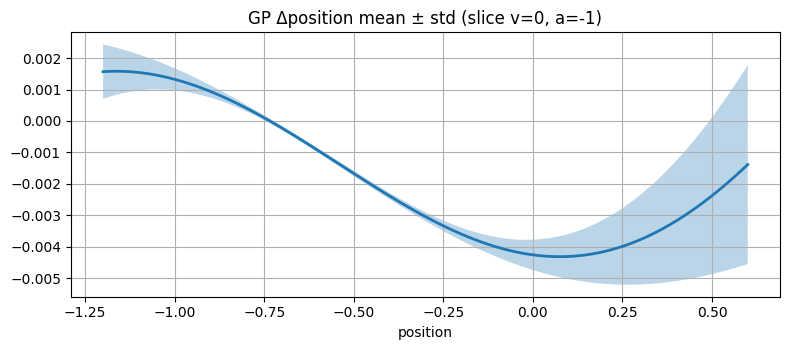


===== CYCLE 2/5 =====
Extending main episode by +50 steps (frontier x=-0.267)
[MPPI] step=50  a0=+0.821  Jmin=14155.90
[MPPI] step=60  a0=+0.935  Jmin=14578.53
[MPPI] step=70  a0=+0.982  Jmin=15226.78
[MPPI] step=80  a0=+0.995  Jmin=15723.46
[MPPI] step=90  a0=+0.184  Jmin=15478.63
[MPPI] step=0  a0=-0.008  Jmin=-0.00
[MPPI] step=10  a0=-0.035  Jmin=-0.00
[MPPI] step=20  a0=-0.057  Jmin=-0.00
[MPPI] step=30  a0=-0.036  Jmin=-0.00
[MPPI] step=40  a0=-0.066  Jmin=-0.00
[MPPI] step=50  a0=-0.073  Jmin=-0.00
[MPPI] step=60  a0=-0.077  Jmin=-0.00
[MPPI] step=70  a0=-0.025  Jmin=-0.00
[MPPI] step=80  a0=+0.000  Jmin=-0.00
[MPPI] step=90  a0=+0.004  Jmin=-0.00
Collected new exploration samples: 100
Retraining GPs on all data …
Training GP…
GP trained.

Training GP…
GP trained.


=== Model Analysis (after retrain) ===
[Δpos GP] lengthscales (pos, vel, act): [7.1855 4.5803 9.0483]  | outputscale: 3.4694  | noise: 0.000114
[Δvel GP] lengthscales (pos, vel, act): [3.4237 8.5901 7.5992]  | output

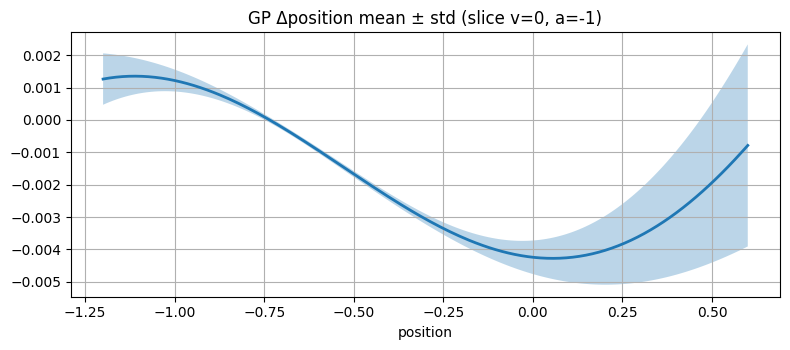


===== CYCLE 3/5 =====
Extending main episode by +50 steps (frontier x=-0.584)
[MPPI] step=100  a0=-0.302  Jmin=13802.43
[MPPI] step=110  a0=-0.460  Jmin=9774.30
[MPPI] step=120  a0=+0.229  Jmin=4390.42
[MPPI] step=130  a0=+0.597  Jmin=-444.16
[MPPI] step=140  a0=+0.548  Jmin=-4551.90
[MPPI] step=0  a0=+0.010  Jmin=-0.00
[MPPI] step=10  a0=-0.028  Jmin=-0.00
[MPPI] step=20  a0=-0.012  Jmin=-0.00
[MPPI] step=30  a0=-0.026  Jmin=-0.00
[MPPI] step=40  a0=-0.044  Jmin=-0.00
[MPPI] step=50  a0=-0.070  Jmin=-0.00
[MPPI] step=60  a0=-0.076  Jmin=-0.00
[MPPI] step=70  a0=-0.056  Jmin=-0.00
[MPPI] step=80  a0=-0.005  Jmin=-0.00
[MPPI] step=90  a0=-0.001  Jmin=-0.00
Collected new exploration samples: 100
Retraining GPs on all data …
Training GP…
GP trained.

Training GP…
GP trained.


=== Model Analysis (after retrain) ===
[Δpos GP] lengthscales (pos, vel, act): [3.9231 4.0097 9.3295]  | outputscale: 3.6367  | noise: 0.000133
[Δvel GP] lengthscales (pos, vel, act): [ 2.1313  0.1208 13.0166]  | o

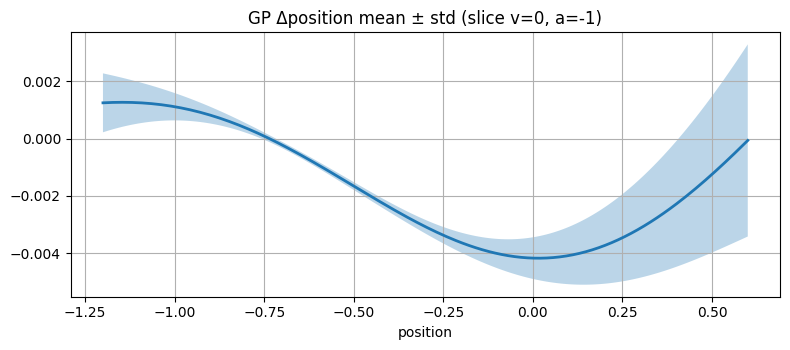


===== CYCLE 4/5 =====
Extending main episode by +50 steps (frontier x=-0.003)
[MPPI] step=150  a0=+0.569  Jmin=-21680.84
[MPPI] step=160  a0=-0.049  Jmin=-13122.63
[MPPI] step=170  a0=-0.176  Jmin=-33949.85
🎉 SUCCESS! Goal reached in main episode at step 172. Terminating and plotting.


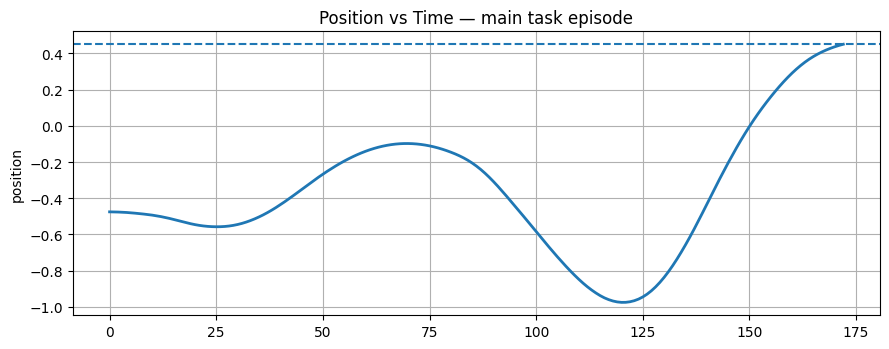

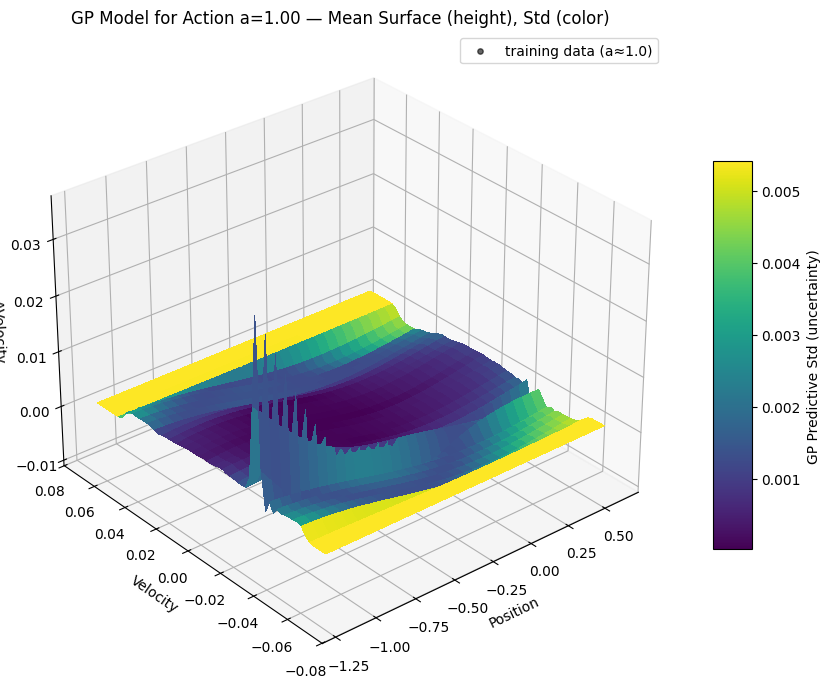

SUCCESS observed: True   MAIN-EPISODE STEPS: 172


In [48]:
# %matplotlib inline

import numpy as np
import torch
import gpytorch
import gymnasium as gym
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D)



class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel='RBF', ard_dims=None):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        if kernel == 'RBF':
            base_kernel = gpytorch.kernels.RBFKernel(ard_num_dims=ard_dims)
        else:
            base_kernel = gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=ard_dims)
        self.covar_module = gpytorch.kernels.ScaleKernel(base_kernel)

    def forward(self, x):
        return gpytorch.distributions.MultivariateNormal(
            self.mean_module(x), self.covar_module(x)
        )

class GPManager:
    def __init__(self, kernel='RBF', lr=0.03, iters=500):
        self.kernel = kernel
        self.lr = lr
        self.iters = iters

    def fit(self, X, Y):
        print("Training GP…")
        X = torch.tensor(X, dtype=torch.float32)
        Y = torch.tensor(Y, dtype=torch.float32)

        self.X_mean = X.mean(0)
        self.X_std  = X.std(0).clamp_min(1e-8)
        Xn = (X - self.X_mean) / self.X_std

        self.Y_mean = Y.mean()
        self.Y_std  = Y.std().clamp_min(1e-8)
        Yn = (Y - self.Y_mean) / self.Y_std

        self.likelihood = gpytorch.likelihoods.GaussianLikelihood()
        self.model = ExactGPModel(Xn, Yn, self.likelihood,
                                  kernel=self.kernel, ard_dims=X.shape[-1])

        opt = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihood, self.model)

        self.model.train(); self.likelihood.train()
        for _ in range(self.iters):
            opt.zero_grad()
            pred = self.model(Xn)
            loss = -mll(pred, Yn)
            loss.backward()
            opt.step()

        self.model.eval(); self.likelihood.eval()
        print("GP trained.\n")

    def predict_mean_var(self, X):
        X = torch.tensor(X, dtype=torch.float32)
        Xn = (X - self.X_mean) / self.X_std
        with torch.no_grad():
            pred = self.model(Xn)
        mean = pred.mean.numpy() * float(self.Y_std) + float(self.Y_mean)
        var  = pred.variance.numpy() * float(self.Y_std)**2
        return mean, var



SEED = 7
rng = np.random.RandomState(SEED)

env_init = gym.make("MountainCarContinuous-v0", max_episode_steps=500)
dataX, dataY = [], []

obs, _ = env_init.reset(seed=SEED)
for _ in range(300):
    a = env_init.action_space.sample()
    next_obs, _, term, trunc, _ = env_init.step(a)
    dataX.append(np.array([obs[0], obs[1], float(a[0])], dtype=np.float32))
    dataY.append(next_obs - obs)
    obs = next_obs
    if term or trunc:
        obs, _ = env_init.reset()
env_init.close()

X = np.asarray(dataX, dtype=np.float32)[::2]
Y = np.asarray(dataY, dtype=np.float32)[::2]

gps = [GPManager(), GPManager()]
gps[0].fit(X, Y[:, 0])  # Δposition
gps[1].fit(X, Y[:, 1])  # Δvelocity



def gp_step_mean_var(states, actions):
    """
    states: (N,2) [pos, vel]
    actions: (N,) in [-1,1]
    returns: next_states (N,2), total_var (N,)
    """
    N = states.shape[0]
    inp = np.zeros((N, 3), dtype=np.float32)
    inp[:, :2] = states
    inp[:, 2]  = actions

    mean_p, var_p = gps[0].predict_mean_var(inp)
    mean_v, var_v = gps[1].predict_mean_var(inp)

    next_states = states.copy()
    next_states[:, 0] += mean_p
    next_states[:, 1] += mean_v
    total_var = var_p + var_v
    return next_states, total_var

GOAL = 0.45

TASK_W = dict(
    position=400.0,
    velocity=150.0,
    energy=1.0,
    stop_boost=3000.0,
    time=1.5,
)

def task_cost(states, actions, w):
    x = states[:, 0]
    v = states[:, 1]
    dist = np.abs(x - GOAL)

    pos    = w["position"] * (np.tanh(dist * 2.0) ** 2)
    vel    = (w["velocity"] + w["stop_boost"] * np.exp(-20.0 * dist)) * (v ** 2)
    energy = w["energy"] * (actions ** 2)
    time   = w["time"]
    steady = np.where((dist < 0.03) & (np.abs(v) < 0.005), -1000.0, 0.0)
    return pos + vel + energy + time + steady

def explore_cost(var):
    return -var  # encourage visiting high-uncertainty regions


class MPPIController:
    def __init__(self, H, K, sigma, lam, gamma, wt_task=1.0, wt_explore=0.0):
        self.H, self.K = int(H), int(K)
        self.sigma, self.lam, self.gamma = float(sigma), float(lam), float(gamma)
        self.wt_task, self.wt_explore = float(wt_task), float(wt_explore)
        self.U_mean = np.zeros(self.H, dtype=np.float32)
        self.debug_step = 0

    def action(self, state):
        noise = rng.randn(self.K, self.H).astype(np.float32) * self.sigma
        U = np.clip(self.U_mean + noise, -1.0, 1.0)

        S = np.repeat(state[None, :], self.K, axis=0)
        J_task = np.zeros(self.K, dtype=np.float64)
        J_expl = np.zeros(self.K, dtype=np.float64)
        disc = 1.0

        for t in range(self.H):
            a_t = U[:, t]
            S, var = gp_step_mean_var(S, a_t)
            if self.wt_task != 0.0:
                J_task += task_cost(S, a_t, TASK_W) * disc
            if self.wt_explore != 0.0:
                J_expl += (-var) * disc
            disc *= self.gamma

        J = self.wt_task * J_task + self.wt_explore * J_expl
        Jmin = J.min()
        w = np.exp(-(J - Jmin) / (self.lam + 1e-8))
        w /= w.sum()

        new_mean = np.sum(U * w[:, None], axis=0)
        self.U_mean = 0.8 * self.U_mean + 0.2 * new_mean

        if (self.debug_step % 10) == 0:
            print(f"[MPPI] step={self.debug_step}  a0={self.U_mean[0]:+.3f}  Jmin={Jmin:.2f}")
        self.debug_step += 1
        return float(self.U_mean[0])

TaskMPPI    = lambda: MPPIController(H=60, K=256, sigma=0.6, lam=1.0,  gamma=0.99, wt_task=1.0, wt_explore=0.0)
ExploreMPPI = lambda: MPPIController(H=30, K=256, sigma=0.6, lam=1.0,  gamma=0.99, wt_task=0.0, wt_explore=1.0)



def plot_uncertainty():
    gp = gps[0]  # Δposition GP
    p_grid = np.linspace(-1.2, 0.6, 200, dtype=np.float32)
    v_fixed, a_fixed = 0.0, -1.0
    Xq = np.column_stack([p_grid, np.full_like(p_grid, v_fixed),
                          np.full_like(p_grid, a_fixed)])
    Mean, Var = gp.predict_mean_var(Xq)
    Std = np.sqrt(Var)
    plt.figure(figsize=(8, 3.6))
    plt.plot(p_grid, Mean, lw=2)
    plt.fill_between(p_grid, Mean-Std, Mean+Std, alpha=0.30)
    plt.title("GP Δposition mean ± std (slice v=0, a=-1)")
    plt.xlabel("position")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def print_model_analysis():
    def hp_str(gpm):
        m = gpm.model
        with torch.no_grad():
            ls = m.covar_module.base_kernel.lengthscale.flatten().cpu().numpy()
            os = float(m.covar_module.outputscale.cpu())
            nz = float(gpm.likelihood.noise_covar.noise.cpu())
        return ls, os, nz

    ls0, os0, n0 = hp_str(gps[0])
    ls1, os1, n1 = hp_str(gps[1])

    print("\n=== Model Analysis (after retrain) ===")
    print("[Δpos GP] lengthscales (pos, vel, act):", np.round(ls0, 4),
          " | outputscale:", round(os0, 4), " | noise:", round(n0, 6))
    print("[Δvel GP] lengthscales (pos, vel, act):", np.round(ls1, 4),
          " | outputscale:", round(os1, 4), " | noise:", round(n1, 6))

    pos = np.linspace(-1.2, 0.6, 25, dtype=np.float32)
    vel = np.linspace(-0.07, 0.07, 21, dtype=np.float32)
    act = np.linspace(-1.0, 1.0, 21, dtype=np.float32)
    PP, VV, AA = np.meshgrid(pos, vel, act, indexing='ij')
    grid = np.stack([PP.ravel(), VV.ravel(), AA.ravel()], axis=1)
    _, var_p = gps[0].predict_mean_var(grid)
    _, var_v = gps[1].predict_mean_var(grid)
    tot = var_p + var_v
    print(f"Uncertainty summary over grid ({len(grid)} pts): "
          f"mean={tot.mean():.6f}, std={tot.std():.6f}, "
          f"min={tot.min():.6f}, max={tot.max():.6f}\n")



def exploration_rollout_from(frontier_state, n_steps=500, use_mppi=True, seed=123):
    env = gym.make("MountainCarContinuous-v0")  # headless = faster
    env.reset(seed=seed)
    env.unwrapped.state = np.array(frontier_state, dtype=np.float32)

    newX, newY = [], []
    s = np.array(frontier_state, dtype=np.float32)
    ctrl = ExploreMPPI() if use_mppi else None

    for _ in range(n_steps):
        if use_mppi:
            a = ctrl.action(s)
        else:
            A = np.linspace(-1.0, 1.0, 21, dtype=np.float32)
            S_t = np.repeat(s[None, :], len(A), axis=0)
            _, var = gp_step_mean_var(S_t, A)
            a = float(A[np.argmax(var)])

        s_next, _, term, trunc, _ = env.step([a])

        newX.append(np.array([s[0], s[1], a], dtype=np.float32))
        newY.append(s_next - s)
        s = s_next

        if term or trunc:
            env.reset()
            env.unwrapped.state = np.array(frontier_state, dtype=np.float32)
            s = np.array(frontier_state, dtype=np.float32)

    env.close()
    return np.asarray(newX, dtype=np.float32), np.asarray(newY, dtype=np.float32)



def plot_gp_surface_for_action(action_val=1.0, which='vel', a_tolerance=0.15):
    """
    3D surface over (pos, vel) with fixed action = action_val.
    - Surface height = GP mean Δstate
    - Surface color  = GP predictive Std (uncertainty)
    - Overlays training points near that action
    """
    idx = 1 if which == 'vel' else 0
    gp = gps[idx]

    pos = np.linspace(-1.2, 0.6, 61, dtype=np.float32)
    vel = np.linspace(-0.07, 0.07, 61, dtype=np.float32)
    P, V = np.meshgrid(pos, vel, indexing='ij')

    # Query inputs with fixed action
    A = np.full(P.size, float(action_val), dtype=np.float32)
    grid = np.column_stack([P.ravel(), V.ravel(), A])

    Mean, Var = gp.predict_mean_var(grid)
    Mean = Mean.reshape(P.shape)
    Std  = np.sqrt(Var).reshape(P.shape)

    # Training data near that action
    mask = np.abs(X[:, 2] - action_val) <= a_tolerance
    pos_tr = X[mask, 0]
    vel_tr = X[mask, 1]
    dpos_tr = Y[mask, 0]
    dvel_tr = Y[mask, 1]
    dZ = dvel_tr if idx == 1 else dpos_tr

    # Normalize Std for color mapping
    norm = plt.Normalize(vmin=Std.min(), vmax=Std.max())
    colors = plt.cm.viridis(norm(Std))


    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(
        P, V, Mean,
        facecolors=colors, linewidth=0, antialiased=False, shade=False
    )

    # Colorbar = predictive uncertainty
    m = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    m.set_array(Std)
    cbar = fig.colorbar(m, ax=ax, shrink=0.6, aspect=10)
    cbar.set_label('GP Predictive Std (uncertainty)')

    # Overlay raw data (samples with similar a)
    if pos_tr.size > 0:
        ax.scatter(pos_tr, vel_tr, dZ, color='k', s=15, alpha=0.6,
                   label=f"training data (a≈{action_val})")

    # Labels and title
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_zlabel('ΔVelocity' if idx == 1 else 'ΔPosition')
    ax.set_title(f"GP Model for Action a={action_val:.2f} — Mean Surface (height), Std (color)")
    ax.view_init(elev=30, azim=230)
    if pos_tr.size > 0:
        ax.legend()
    plt.tight_layout()
    plt.show()



def run_progressive_episode(prefix_step=50, explore_steps=100, max_total_steps=1000, n_cycles=5):
    env = gym.make("MountainCarContinuous-v0", render_mode="human")
    obs, _ = env.reset(seed=SEED)

    task_ctrl = TaskMPPI()

    # Logs for the MAIN task episode (single continuous run)
    pos_hist = [float(obs[0])]

    frontier_state = obs.copy()
    total_steps = 0

    global X, Y, gps

    def finalize_and_plot():

        t = np.arange(len(pos_hist))
        plt.figure(figsize=(9, 3.6))
        plt.plot(t, pos_hist, lw=2)
        plt.axhline(GOAL, ls='--')
        plt.ylabel("position")
        plt.title("Position vs Time — main task episode")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


        plot_gp_surface_for_action(action_val=1.0, which='vel', a_tolerance=0.15)


    for cyc in range(1, n_cycles + 1):
        print(f"\n===== CYCLE {cyc}/{n_cycles} =====")
        print(f"Extending main episode by +{prefix_step} steps (frontier x={frontier_state[0]:+.3f})")


        steps_this_cycle = 0
        while steps_this_cycle < prefix_step and total_steps < max_total_steps:
            a = task_ctrl.action(obs)
            next_obs, _, term, trunc, _ = env.step([a])
            pos_hist.append(float(next_obs[0]))

            obs = next_obs
            frontier_state = obs.copy()
            steps_this_cycle += 1
            total_steps += 1

            if obs[0] >= GOAL:
                print(f"🎉 SUCCESS! Goal reached in main episode at step {total_steps}. Terminating and plotting.")
                env.close()
                finalize_and_plot()
                return dict(success=True, steps=total_steps, pos=np.array(pos_hist))

            if term or trunc:
                print("Env terminated early — restoring frontier state and continuing.")
                env.reset()
                env.unwrapped.state = np.array(frontier_state, dtype=np.float32)
                obs = frontier_state.copy()


        newX, newY = exploration_rollout_from(frontier_state, n_steps=explore_steps, use_mppi=True, seed=SEED+total_steps)
        print("Collected new exploration samples:", len(newX))


        X = np.vstack([X, newX])
        Y = np.vstack([Y, newY])


        print("Retraining GPs on all data …")
        gps[0].fit(X, Y[:, 0])
        gps[1].fit(X, Y[:, 1])


        print_model_analysis()
        plot_uncertainty()

        if total_steps >= max_total_steps:
            print("Reached max_total_steps; stopping cycles.")
            break

    env.close()
    print("Did not reach GOAL within the configured cycles; plotting what we have.")
    finalize_and_plot()
    return dict(success=False, steps=total_steps, pos=np.array(pos_hist))

results = run_progressive_episode(prefix_step=50, explore_steps=100, max_total_steps=1000, n_cycles=5)
print("SUCCESS observed:", results["success"], "  MAIN-EPISODE STEPS:", results["steps"])
